In [1]:
# ============================================================
# COMPLETE COLAB CROWD COUNTING - NO ERRORS
# ============================================================

from google.colab import drive
drive.mount('/content/drive')

import os, cv2, numpy as np, torch, torch.nn as nn, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg16

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"✅ Device: {device}\n")

# ============================================================
# PATHS
# ============================================================

BASE = "/content/drive/MyDrive/ShanghaiTech"
TRAIN_IMG = f"{BASE}/part_A/train_data/images"
TRAIN_DEN = f"{BASE}/preprocessed/train_density"
TEST_IMG = f"{BASE}/part_A/test_data/images"
TEST_DEN = f"{BASE}/preprocessed/test_density"

# ============================================================
# DATASET
# ============================================================

class CrowdDataset(Dataset):
    def __init__(self, img_dir, den_dir, augment=False):
        self.img_dir = img_dir
        self.den_dir = den_dir
        self.augment = augment

        imgs = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
        dens = sorted([f for f in os.listdir(den_dir) if f.endswith(".npy")])

        self.pairs = []
        for img in imgs:
            base = img.replace(".jpg", "")
            den = base + ".npy"
            if den in dens:
                self.pairs.append((img, den))

        print(f"  Loaded {len(self.pairs)} pairs")

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        img_file, den_file = self.pairs[idx]

        # Load image
        img = cv2.cvtColor(cv2.imread(os.path.join(self.img_dir, img_file)), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (512, 512)).astype("float32") / 255.0

        # Load density
        den = np.load(os.path.join(self.den_dir, den_file)).astype("float32")

        # Resize 256→64 if needed, preserve sum
        if den.shape != (64, 64):
            old_sum = den.sum()
            den = cv2.resize(den, (64, 64), interpolation=cv2.INTER_AREA)
            new_sum = den.sum()
            if new_sum > 0:
                den = den * (old_sum / new_sum)

        # Scale down magnitude
        den = den / 10.0

        # Augment
        if self.augment and np.random.rand() > 0.5:
            img = np.fliplr(img).copy()
            den = np.fliplr(den).copy()

        # To tensor
        img = torch.from_numpy(img.copy()).permute(2, 0, 1).float()
        mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
        std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
        img = (img - mean) / std

        den = torch.from_numpy(den.copy()).unsqueeze(0).float()
        return img, den

print("📦 Creating datasets...")
train_ds = CrowdDataset(TRAIN_IMG, TRAIN_DEN, augment=True)
test_ds = CrowdDataset(TEST_IMG, TEST_DEN, augment=False)

train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=0)
test_loader = DataLoader(test_ds, batch_size=1, shuffle=False, num_workers=0)

print(f"✓ Train: {len(train_loader)} batches")
print(f"✓ Test: {len(test_loader)} batches\n")





Mounted at /content/drive
✅ Device: cuda

📦 Creating datasets...
  Loaded 300 pairs
  Loaded 182 pairs
✓ Train: 75 batches
✓ Test: 182 batches



In [2]:

# ============================================================
# MODEL
# ============================================================

class CSRNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = vgg16(weights="DEFAULT")
        self.backbone = nn.Sequential(*list(vgg.features.children())[:23])
        self.regressor = nn.Sequential(
            nn.Conv2d(512, 256, 3, padding=1), nn.ReLU(),
            nn.Conv2d(256, 128, 3, padding=1), nn.ReLU(),
            nn.Conv2d(128, 1, 1)
        )

    def forward(self, x):
        return self.regressor(self.backbone(x))

model = CSRNet().to(device)
print(f"✅ Model loaded\n")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 137MB/s] 


✅ Model loaded



In [4]:
# ============================================================
# TRAINING
# ============================================================

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)

EPOCHS = 30  # Faster
train_losses = []
best_mae = float('inf')

print(f"🚀 Training for {EPOCHS} epochs...\n")

for epoch in range(1, EPOCHS + 1):
    model.train()
    epoch_loss = 0.0

    for imgs, dens in train_loader:
        imgs, dens = imgs.to(device), dens.to(device)

        optimizer.zero_grad()
        preds = model(imgs)

        if preds.shape[2:] != dens.shape[2:]:
            dens = torch.nn.functional.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)

        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Eval every 3 epochs (faster)
    if epoch % 3 == 0 or epoch == EPOCHS:
        model.eval()
        mae_sum, n = 0, 0
        with torch.no_grad():
            for imgs, dens in test_loader:
                imgs, dens = imgs.to(device), dens.to(device)
                preds = model(imgs)

                if preds.shape[2:] != dens.shape[2:]:
                    dens = torch.nn.functional.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)

                mae_sum += abs(preds.sum().item() - dens.sum().item())
                n += 1

        test_mae = mae_sum / n
        print(f"Epoch {epoch}/{EPOCHS} | Loss: {avg_loss:.6f} | MAE: {test_mae:.4f}")

        if test_mae < best_mae:
            best_mae = test_mae
            torch.save(model.state_dict(), "/content/best_model.pth")

print("\n✅ Training complete!")
torch.save(model.state_dict(), "/content/final_model.pth")


🚀 Training for 30 epochs...

Epoch 3/30 | Loss: 0.000331 | MAE: 20.9293
Epoch 6/30 | Loss: 0.000750 | MAE: 22.0359
Epoch 9/30 | Loss: 0.000821 | MAE: 22.0627
Epoch 12/30 | Loss: 0.000772 | MAE: 28.9919
Epoch 15/30 | Loss: 0.000889 | MAE: 25.3163
Epoch 18/30 | Loss: 0.000817 | MAE: 24.9066
Epoch 21/30 | Loss: 0.000822 | MAE: 23.4030
Epoch 24/30 | Loss: 0.000889 | MAE: 28.9189
Epoch 27/30 | Loss: 0.000889 | MAE: 31.9540
Epoch 30/30 | Loss: 0.000887 | MAE: 31.7072

✅ Training complete!


In [5]:
# Load best model and fine-tune with smaller LR
model.load_state_dict(torch.load("/content/best_model.pth", map_location=device))

optimizer = torch.optim.Adam(model.parameters(), lr=5e-5, weight_decay=1e-4)
EPOCHS_FT = 15
print("\n🚀 Fine-tuning for", EPOCHS_FT, "epochs with lr=5e-5...\n")

for epoch in range(1, EPOCHS_FT + 1):
    model.train()
    epoch_loss = 0.0
    for imgs, dens in train_loader:
        imgs, dens = imgs.to(device), dens.to(device)

        optimizer.zero_grad()
        preds = model(imgs)
        if preds.shape[2:] != dens.shape[2:]:
            dens = torch.nn.functional.interpolate(
                dens, size=preds.shape[2:], mode='bilinear', align_corners=False
            )
        loss = criterion(preds, dens)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(train_loader)

    # quick MAE on small subset
    model.eval()
    mae_sum, n = 0, 0
    with torch.no_grad():
        for i, (imgs, dens) in enumerate(test_loader):
            if i >= 5:   # only first 5 batches to be fast
                break
            imgs, dens = imgs.to(device), dens.to(device)
            preds = model(imgs)
            if preds.shape[2:] != dens.shape[2:]:
                dens = torch.nn.functional.interpolate(
                    dens, size=preds.shape[2:], mode='bilinear', align_corners=False
                )
            mae_sum += abs(preds.sum().item() - dens.sum().item())
            n += 1
    mae_ft = mae_sum / n
    print(f"FT Epoch {epoch}/{EPOCHS_FT} | Loss: {avg_loss:.6f} | Quick MAE: {mae_ft:.2f}")



🚀 Fine-tuning for 15 epochs with lr=5e-5...

FT Epoch 1/15 | Loss: 0.000285 | Quick MAE: 48.33
FT Epoch 2/15 | Loss: 0.000317 | Quick MAE: 37.96
FT Epoch 3/15 | Loss: 0.000249 | Quick MAE: 26.36
FT Epoch 4/15 | Loss: 0.000286 | Quick MAE: 24.65
FT Epoch 5/15 | Loss: 0.000465 | Quick MAE: 28.48
FT Epoch 6/15 | Loss: 0.000316 | Quick MAE: 14.14
FT Epoch 7/15 | Loss: 0.000310 | Quick MAE: 13.51
FT Epoch 8/15 | Loss: 0.000306 | Quick MAE: 14.02
FT Epoch 9/15 | Loss: 0.000298 | Quick MAE: 17.58
FT Epoch 10/15 | Loss: 0.000299 | Quick MAE: 13.85
FT Epoch 11/15 | Loss: 0.000310 | Quick MAE: 38.56
FT Epoch 12/15 | Loss: 0.000299 | Quick MAE: 13.88
FT Epoch 13/15 | Loss: 0.000441 | Quick MAE: 23.70
FT Epoch 14/15 | Loss: 0.000327 | Quick MAE: 40.85
FT Epoch 15/15 | Loss: 0.000353 | Quick MAE: 16.26


In [6]:
torch.save(model.state_dict(), "/content/best_model_ft.pth")
print("Saved fine-tuned model.")


Saved fine-tuned model.


In [7]:

# ============================================================
# EVALUATION
# ============================================================

model.load_state_dict(torch.load("/content/best_model.pth", map_location=device))

def evaluate(model, loader, device):
    model.eval()
    mae, mse, n = 0, 0, 0
    preds_all, gts_all = [], []

    with torch.no_grad():
        for imgs, dens in loader:
            imgs = imgs.to(device)
            dens = dens.to(device)
            preds = model(imgs)

            if preds.shape[2:] != dens.shape[2:]:
                dens = torch.nn.functional.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)

            pred_c = preds.sum(dim=(1,2,3)).cpu().numpy()
            gt_c = dens.sum(dim=(1,2,3)).cpu().numpy()

            mae += np.abs(pred_c - gt_c).sum()
            mse += ((pred_c - gt_c)**2).sum()
            n += len(pred_c)

            preds_all.extend(pred_c)
            gts_all.extend(gt_c)

    mae = mae / n
    rmse = np.sqrt(mse / n)
    preds_all = np.array(preds_all)
    gts_all = np.array(gts_all)
    mape = np.mean(np.abs(preds_all - gts_all) / (gts_all + 1)) * 100

    return mae, rmse, mape, preds_all, gts_all

mae, rmse, mape, preds, gts = evaluate(model, test_loader, device)

print("\n" + "="*60)
print("📊 FINAL RESULTS")
print("="*60)
print(f"MAE:        {mae:.4f} people")
print(f"RMSE:       {rmse:.4f} people")
print(f"MAPE:       {mape:.2f}%")
print(f"Mean GT:    {gts.mean():.2f}")
print(f"Mean Pred:  {preds.mean():.2f}")
print("="*60)



📊 FINAL RESULTS
MAE:        20.9293 people
RMSE:       33.9525 people
MAPE:       44.48%
Mean GT:    43.33
Mean Pred:  29.64


In [8]:

# ============================================================
# EVALUATION
# ============================================================

model.load_state_dict(torch.load("/content/best_model_ft.pth", map_location=device))

def evaluate(model, loader, device):
    model.eval()
    mae, mse, n = 0, 0, 0
    preds_all, gts_all = [], []

    with torch.no_grad():
        for imgs, dens in loader:
            imgs = imgs.to(device)
            dens = dens.to(device)
            preds = model(imgs)

            if preds.shape[2:] != dens.shape[2:]:
                dens = torch.nn.functional.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)

            pred_c = preds.sum(dim=(1,2,3)).cpu().numpy()
            gt_c = dens.sum(dim=(1,2,3)).cpu().numpy()

            mae += np.abs(pred_c - gt_c).sum()
            mse += ((pred_c - gt_c)**2).sum()
            n += len(pred_c)

            preds_all.extend(pred_c)
            gts_all.extend(gt_c)

    mae = mae / n
    rmse = np.sqrt(mse / n)
    preds_all = np.array(preds_all)
    gts_all = np.array(gts_all)
    mape = np.mean(np.abs(preds_all - gts_all) / (gts_all + 1)) * 100

    return mae, rmse, mape, preds_all, gts_all

mae, rmse, mape, preds, gts = evaluate(model, test_loader, device)

print("\n" + "="*60)
print("📊 FINAL RESULTS")
print("="*60)
print(f"MAE:        {mae:.4f} people")
print(f"RMSE:       {rmse:.4f} people")
print(f"MAPE:       {mape:.2f}%")
print(f"Mean GT:    {gts.mean():.2f}")
print(f"Mean Pred:  {preds.mean():.2f}")
print("="*60)



📊 FINAL RESULTS
MAE:        14.9289 people
RMSE:       22.6250 people
MAPE:       38.36%
Mean GT:    43.33
Mean Pred:  38.35


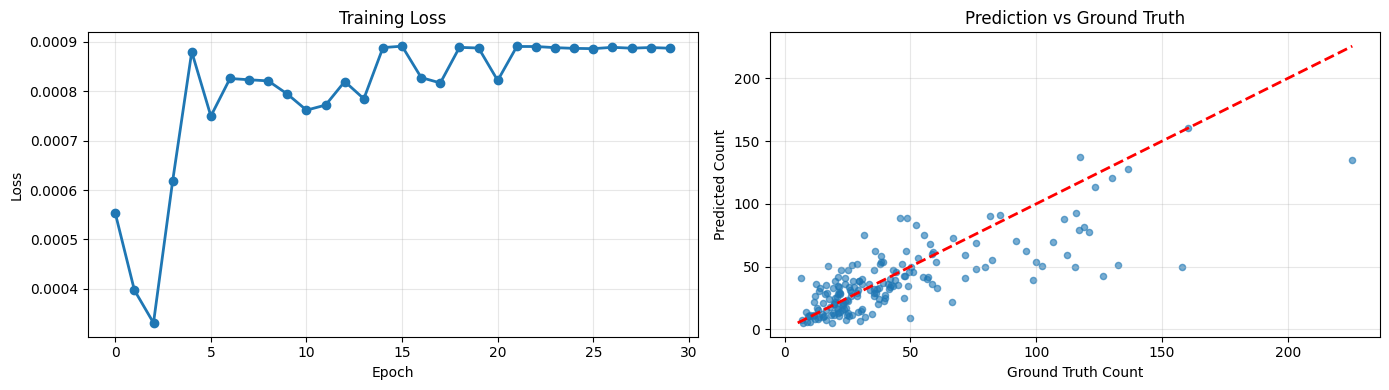


✅ Results saved to /content/training_results.png
✅ Best model saved to /content/best_model.pth


In [9]:

# ============================================================
# PLOT
# ============================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(train_losses, marker='o', linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True, alpha=0.3)

ax2.scatter(gts, preds, alpha=0.6, s=20)
min_val = min(gts.min(), preds.min())
max_val = max(gts.max(), preds.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax2.set_xlabel("Ground Truth Count")
ax2.set_ylabel("Predicted Count")
ax2.set_title("Prediction vs Ground Truth")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("/content/training_results.png", dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Results saved to /content/training_results.png")
print("✅ Best model saved to /content/best_model.pth")


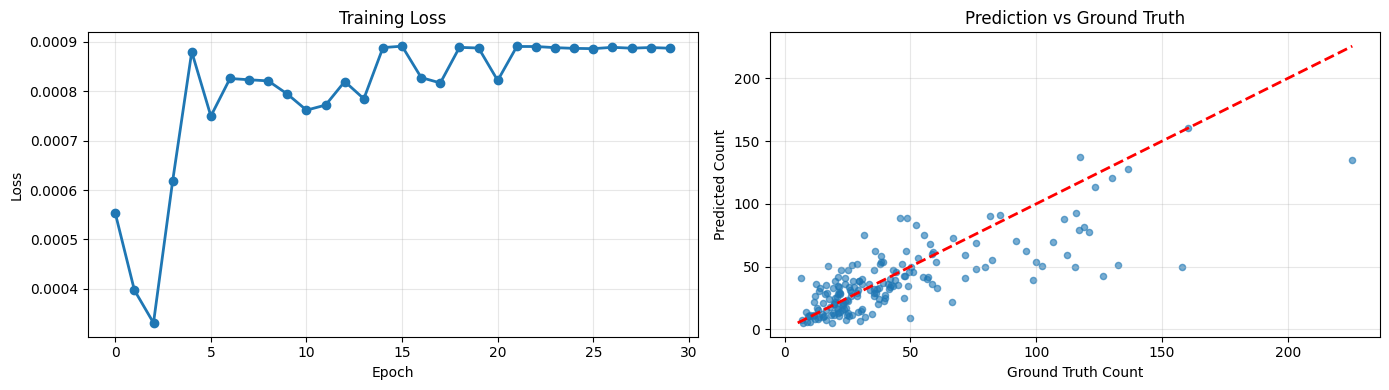


✅ Results saved to /content/training_results.png
✅ Best model saved to /content/best_model_ft.pth


In [10]:

# ============================================================
# PLOT
# ============================================================

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

ax1.plot(train_losses, marker='o', linewidth=2)
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Loss")
ax1.set_title("Training Loss")
ax1.grid(True, alpha=0.3)

ax2.scatter(gts, preds, alpha=0.6, s=20)
min_val = min(gts.min(), preds.min())
max_val = max(gts.max(), preds.max())
ax2.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2)
ax2.set_xlabel("Ground Truth Count")
ax2.set_ylabel("Predicted Count")
ax2.set_title("Prediction vs Ground Truth")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("/content/training_results.png", dpi=100, bbox_inches='tight')
plt.show()

print("\n✅ Results saved to /content/training_results.png")
print("✅ Best model saved to /content/best_model_ft.pth")


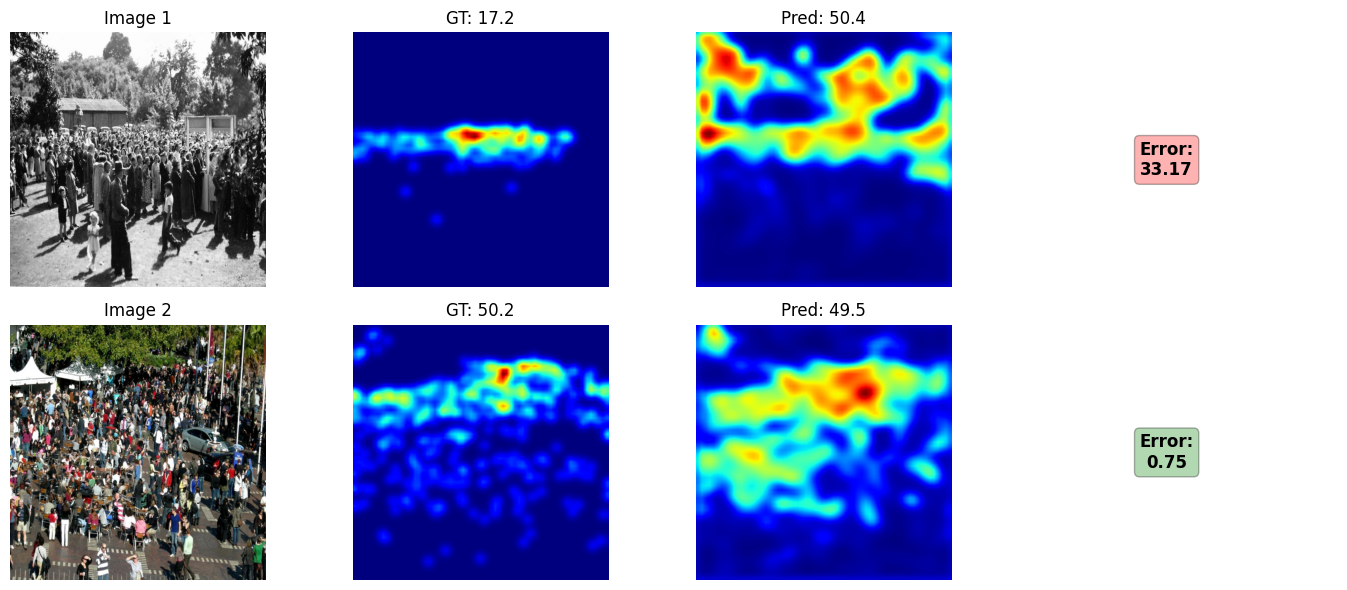

✅ Visualizations saved to /content/visualizations.png


In [11]:

# ============================================================
# SAMPLE VISUALIZATION
# ============================================================

fig, axes = plt.subplots(2, 4, figsize=(14, 6))

model.eval()
idx = 0
for imgs, dens in test_loader:
    if idx >= 2:
        break

    imgs_viz = imgs[0].cpu().clone()
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    imgs_viz = (imgs_viz * std) + mean
    imgs_viz = np.clip(imgs_viz.permute(1, 2, 0).numpy(), 0, 1)

    with torch.no_grad():
        preds = model(imgs.to(device))

    if preds.shape[2:] != dens.shape[2:]:
        dens = torch.nn.functional.interpolate(dens, size=preds.shape[2:], mode='bilinear', align_corners=False)

    pred_map = preds[0, 0].cpu().numpy()
    gt_map = dens[0, 0].cpu().numpy()

    axes[idx, 0].imshow(imgs_viz)
    axes[idx, 0].set_title(f"Image {idx+1}")
    axes[idx, 0].axis("off")

    axes[idx, 1].imshow(cv2.resize(gt_map, (512, 512)), cmap='jet')
    axes[idx, 1].set_title(f"GT: {gt_map.sum():.1f}")
    axes[idx, 1].axis("off")

    axes[idx, 2].imshow(cv2.resize(pred_map, (512, 512)), cmap='jet')
    axes[idx, 2].set_title(f"Pred: {pred_map.sum():.1f}")
    axes[idx, 2].axis("off")

    error = abs(pred_map.sum() - gt_map.sum())
    color = 'green' if error < 5 else 'orange' if error < 10 else 'red'
    axes[idx, 3].text(0.5, 0.5, f"Error:\n{error:.2f}", ha='center', va='center',
                     fontsize=12, fontweight='bold',
                     bbox=dict(boxstyle='round', facecolor=color, alpha=0.3))
    axes[idx, 3].axis("off")

    idx += 1

plt.tight_layout()
plt.savefig("/content/visualizations.png", dpi=100, bbox_inches='tight')
plt.show()

print("✅ Visualizations saved to /content/visualizations.png")